# Hindi MNIST CNN
- Dataset: [kaggle](https://www.kaggle.com/datasets/imbikramsaha/hindi-mnist/data)
- Model: Custom CNN Arch

## Import required libraries

In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
%matplotlib inline
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

## Load Data

In [2]:
DATASET_PATH = "../Datasets/Hindi-MNIST/"
os.listdir(DATASET_PATH)

['test', 'train', 'valid']

### Split Test to Valid (90%) - Test (10%)

In [3]:
import shutil
import random
from pathlib import Path

In [4]:
def split_test_to_valid_test(test_dir, valid_dir, split_ratio=0.1, seed=37):
    random.seed(seed)
    valid_dir, test_dir = Path(valid_dir), Path(test_dir)
    valid_dir.mkdir(exist_ok=True)

    for class_folder in test_dir.iterdir():
        if not class_folder.is_dir():
            continue
        class_name = class_folder.name
        images = list(class_folder.glob("*.png"))
        random.shuffle(images)

        n_valid = int(len(images) * split_ratio)
        test_images = images[:n_valid]
        valid_images = images[n_valid:]

        (valid_dir / class_name).mkdir(parents=True, exist_ok=True)

        for img in valid_images:
            shutil.move(str(img), valid_dir / class_name / img.name)
    return len(test_images), len(valid_images)

In [5]:
# split_test_to_valid_test(
#     test_dir=DATASET_PATH+"test",
#     valid_dir=DATASET_PATH+"valid",
# )

### Loading data

In [6]:
transformer = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.ImageFolder(root=DATASET_PATH+"train", transform=transformer)
valid_data = datasets.ImageFolder(root=DATASET_PATH+"valid", transform=transformer)
test_data = datasets.ImageFolder(root=DATASET_PATH+"test", transform=transformer)

dataloader_params = {
    "batch_size": 32,
    "shuffle": True,
    "pin_memory": True,
    "num_workers": 4
}

train_loader = DataLoader(train_data, **dataloader_params)
valid_loader = DataLoader(valid_data, **dataloader_params)
test_loader = DataLoader(test_data, **dataloader_params)

print(f"Train size: {len(train_data)}")
print(f"Valid size: {len(valid_data)}")
print(f"Test size: {len(test_data)}")
print(f"Classes: {train_data.classes}")

Train size: 17000
Valid size: 2700
Test size: 300
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Exploratory Data Analysis (EDA)

Class counts: [1700, 1700, 1700, 1700, 1700, 1700, 1700, 1700, 1700, 1700]


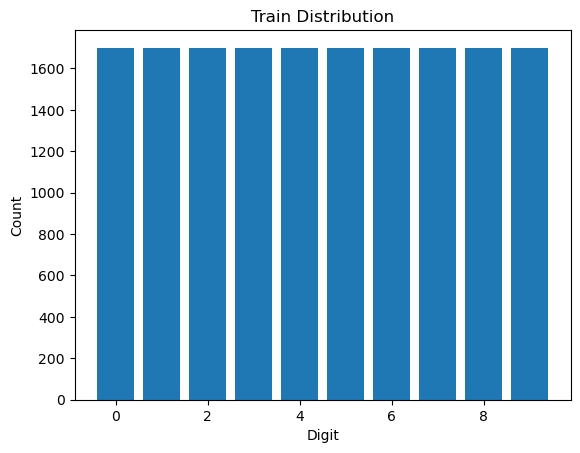

In [7]:
counts = [0]*10
for _, label in train_data:
    counts[label] += 1
print("Class counts:", counts)
plt.bar(range(10), counts)
plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("Train Distribution")
plt.show()

In [8]:
def get_one_sample_per_class(dataset):
    num_classes = len(dataset.classes)
    samples = {}
    for img, lbl in dataset:
        if lbl not in samples:
            samples[lbl] = (img, lbl)
        if len(samples) == num_classes:
            break
    return samples


def show_samples_grid(samples, class_names, cols=10, figsize=(8, 4)):
    fig, axes = plt.subplots(2, 5, figsize=figsize, sharex=True, sharey=True)
    axes = axes.flatten()

    for i, lbl in enumerate(sorted(samples)):
        img, _ = samples[lbl]
        img = img * 0.5 + 0.5  # unnormalize
        axes[i].imshow(img.squeeze(), cmap="gray")
        axes[i].set_title(class_names[lbl])
        # axes[i].axis("off")

    plt.tight_layout()
    plt.show()

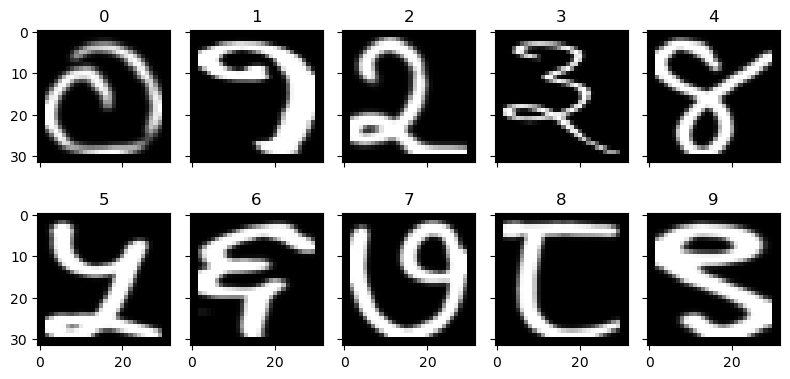

In [9]:
samples = get_one_sample_per_class(train_data)
show_samples_grid(samples, train_data.classes)

## Model

### CNN 1
- 2 Convo layers followed by max pooling
- 1 FC layer
- 1 Dropout 0.5
- 1 Output

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=0),   # out: 26×26
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # out: 13×13

            nn.Conv2d(32, 64, kernel_size=3, padding=0),  # out: 11×11
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # out: 5×5

            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 128),  # fix dimensions
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)


## Training & Evaluation

### Trainer

In [11]:
class Trainer:
    def __init__(self, model, device, train_loader, val_loader, learning_rate):
        self.model = model.to(device)
        self.device = device
        self.train_loader, self.val_loader = train_loader, val_loader
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.train_m = len(self.train_loader.dataset)
        self.val_m = len(self.val_loader.dataset)

    
    def train_epoch(self):
        self.model.train()
        total_loss, accuracy = 0, 0
        for X, y in tqdm(self.train_loader, desc="Train"):
            X, y = X.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            out = self.model(X)
            loss = self.criterion(out, y)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * X.size(0)
            accuracy += (out.argmax(1) == y).sum().item()

        return total_loss/self.train_m, accuracy/self.train_m


    def valid_epoch(self):
        self.model.eval()
        total_loss, acc = 0, 0
        with torch.no_grad():
            for X, y in tqdm(self.val_loader, desc="Validate"):
                X, y = X.to(self.device), y.to(self.device)
                out = self.model(X)
                loss = self.criterion(out, y)

                total_loss += loss.item() * X.size(0)
                acc += (out.argmax(1) == y).sum().item()

        return total_loss/self.val_m, acc/self.val_m

### Model Runner
- to run the model on `n` iterations

In [12]:
class ModelRunner:
    def __init__(self, model, trainer, name="Model"):
        self.model = model
        self.trainer = trainer
        self.name = name
        self.history = []

    def run(self, epochs=5, verbose=True):
        """
        Trains and validates the model for given number of epochs.
        Stores history as (train_loss, train_acc, val_loss, val_acc) per epoch.
        """
        for epoch in range(1, epochs + 1):
            tr_loss, tr_acc = self.trainer.train_epoch()
            val_loss, val_acc = self.trainer.valid_epoch()
            self.history.append((tr_loss, tr_acc, val_loss, val_acc))
            if verbose:
                print(f"{self.name:^10} | Epoch {epoch:>2}: "
                      f"Train Acc: {tr_acc:.3f}, Val Acc: {val_acc:.3f}")
        return self.history

### ModelTrainer

In [ ]:
class ModelTrainer:
    def __init__(self, model, device, train_loader, val_loader, penalty, name="CNN", *, learning_rate=1e-3):
        self.device = device
        self.model = model.to(device)
        self.name = name
        self.train_loader, self.val_loader = train_loader, val_loader
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.history = []

    def run_epoch(self, loader, train=True):
        self.model.train() if train else self.model.eval()
        total_loss, correct, total = 0, 0, 0

        for X, y in tqdm(loader, desc="Train" if train else "Valid"):
            X, y = X.to(device), y.to(device)

            if train:
                self.optimizer.zero_grad()

            with torch.set_grad_enabled(train):
                out = self.model(X)
                loss = self.criterion(out, y)

                if train:
                    loss.backward()
                    self.optimizer.step()

            total += y.size(0)
            total_loss += loss.item() * y.size(0)
            correct += (out.argmax(1) == y).sum().item()

        return total_loss/total, correct/total

    def _run(self, n_iter=5):
        for epoch in range(1, n_iter+1):
            tr_loss, tr_acc = self.run_epoch(self.train_loader, train=True)
            val_loss, val_acc = self.run_epoch(self.val_loader, train=False)

            self.history.append([tr_loss, tr_acc, val_loss, val_acc])
            tqdm.write(
                f"[Epoch {epoch:02d}]\t"
                f"Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f} | "
                f"Valid Loss: {val_loss:.4f}, Acc: {val_acc:.4f}"
            )
        return self.history

    def __call__(self, n_iter=5):
        return self._run(n_iter)

### Training

In [11]:
model = SimpleCNN().to(device)
summary(model)

Layer (type:depth-idx)                   Param #
SimpleCNN                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       18,496
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Flatten: 2-7                      --
│    └─Linear: 2-8                       295,040
│    └─ReLU: 2-9                         --
│    └─Dropout: 2-10                     --
│    └─Linear: 2-11                      1,290
│    └─Softmax: 2-12                     --
Total params: 315,146
Trainable params: 315,146
Non-trainable params: 0

In [12]:
trainer = Trainer(model, device, train_loader, valid_loader, 1e-3)
runner = ModelRunner(
    model=model,
    trainer=trainer
)
history = runner.run(5)

Validate: 100%|████████████████████████████████████████████████████████████████████████| 85/85 [00:25<00:00,  3.35it/s]


  Model    | Epoch  1: Train Acc: 0.780, Val Acc: 0.974


Validate: 100%|████████████████████████████████████████████████████████████████████████| 85/85 [00:22<00:00,  3.71it/s]


  Model    | Epoch  2: Train Acc: 0.950, Val Acc: 0.985


Validate: 100%|████████████████████████████████████████████████████████████████████████| 85/85 [00:22<00:00,  3.71it/s]


  Model    | Epoch  3: Train Acc: 0.963, Val Acc: 0.984


Validate: 100%|████████████████████████████████████████████████████████████████████████| 85/85 [00:23<00:00,  3.69it/s]


  Model    | Epoch  4: Train Acc: 0.971, Val Acc: 0.986


Validate: 100%|████████████████████████████████████████████████████████████████████████| 85/85 [00:23<00:00,  3.59it/s]

  Model    | Epoch  5: Train Acc: 0.974, Val Acc: 0.994


In [13]:
history

[(1.6880346602271585,
  0.7799411764705882,
  1.4882820205335263,
  0.9740740740740741),
 (1.5144640302658081,
  0.9500588235294117,
  1.4772272938269155,
  0.9851851851851852),
 (1.4997478525498333,
  0.9628235294117647,
  1.4768897805390535,
  0.9837037037037037),
 (1.4921587908688714,
  0.9707058823529412,
  1.4755166885587905,
  0.9859259259259259),
 (1.4875772843080408,
  0.9744117647058823,
  1.4681140608257717,
  0.9937037037037038)]

### Evaluation

In [14]:
def plot_training_history(history, title="Training History"):
    """
    history: List of tuples (train_loss, train_acc, val_loss, val_acc)
    """
    train_loss = [h[0] for h in history]
    train_acc = [h[1] for h in history]
    val_loss = [h[2] for h in history]
    val_acc = [h[3] for h in history]
    epochs = range(1, len(history) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Loss
    axs[0].plot(epochs, train_loss, label="Train Loss", marker='o')
    axs[0].plot(epochs, val_loss,   label="Val Loss", marker='s')
    axs[0].set_title("Loss Over Epochs")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    # Plot Accuracy
    axs[1].plot(epochs, train_acc, label="Train Acc", marker='o')
    axs[1].plot(epochs, val_acc,   label="Val Acc", marker='s')
    axs[1].set_title("Accuracy Over Epochs")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

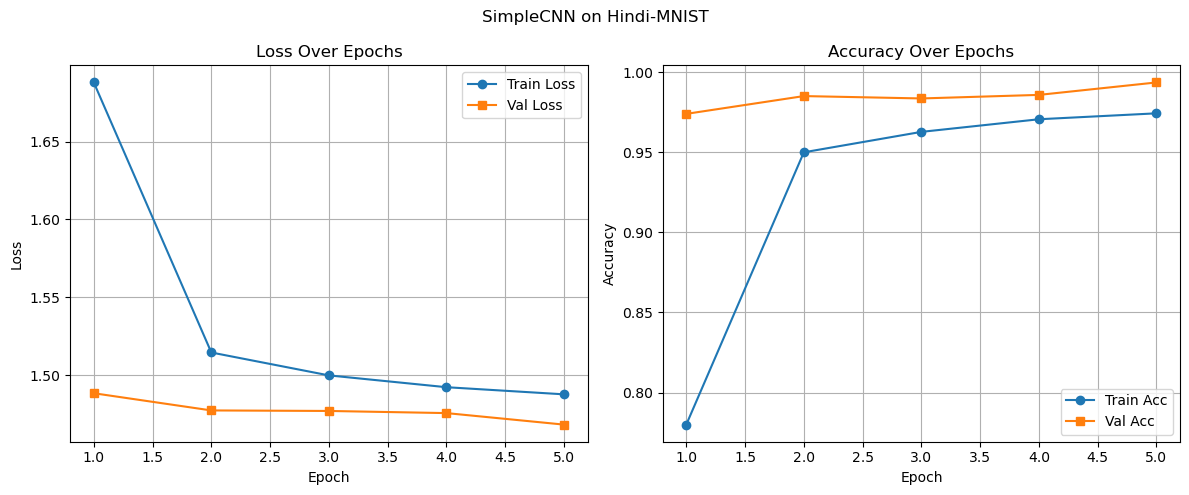

In [15]:
plot_training_history(history, title="SimpleCNN on Hindi-MNIST")

## Predictions

In [16]:
def get_predictions(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            out = model(X)
            pred = out.argmax(dim=1)
            preds.extend(pred.cpu().numpy())
            labels.extend(y.numpy())
    return preds, labels

In [19]:
y_preds, y_true = get_predictions(model, test_loader, device)

In [20]:
def show_predictions(images, preds, labels, class_names, n=10):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img = images[i].squeeze().numpy() * 0.5 + 0.5  # unnormalize
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


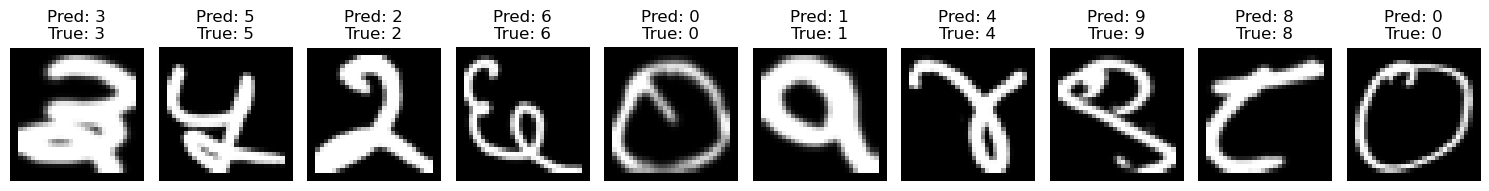

In [22]:
images, labels = next(iter(test_loader))
images = images.to(device)
preds = model(images).argmax(dim=1).cpu().numpy()
show_predictions(images.cpu(), preds, labels, test_data.classes)

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_true, y_preds))
print(confusion_matrix(y_true, y_preds))
print(classification_report(y_true, y_preds, target_names=test_data.classes))

Accuracy: 0.9966666666666667
[[30  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  1  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.97      1.00      0.98        30
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00        30
           6       1.00      1.00      1.00        30
           7       1.00      0.97      0.98        30
           8       1.00      1.00      1.00        30
           9       1.00      1.00      1.00        30

    accuracy                           1.00 

## Save the model

In [25]:
MODEL_PATH = "../Models/Hindi-MNIST/"
# os.mkdir(MODEL_PATH)
torch.save(model, MODEL_PATH+"SimpleCNN_test_epoch5.pt")